## **1-Import libraries**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **2-Load Helper Function**

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-30 07:21:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-30 07:21:26 (51.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## **3-Import Functions Using Helper Functions**

In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## **4-Install and Import Split Folders**

In [4]:
pip install split-folders

In [5]:
import splitfolders

## **5-Mount Data From Google Drive**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **6-Load Data from Google Drive**

In [7]:
import zipfile

# unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Apple_Dataset_only.zip")
zip_ref.extractall()
zip_ref.close()

## **7-Get Class Names Programmatically**

In [8]:
# get the class names prgrammatically
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/Plant_Leaf_Data_set/Apple_Dataset")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # create a list of class_names from the subdirectories
print(class_names)

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy']


## **8-Visualize Our Images**

In [9]:
# let's visualize our image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) # this line means randomly sample one item form the target folder
  print(random_image)

  # read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show thw shape of the image

  return img 

## **9-Split The Folders into Train , Validation and Test Datasets**

In [10]:
splitfolders.ratio("/content/Plant_Leaf_Data_set/Apple_Dataset", output="apple_dataset_splitting",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 4000 files [00:00, 4595.88 files/s]


## **10-Set Train, Test and Validation Paths**

In [75]:
train_dir = "/content/apple_dataset_splitting/train/"
test_dir = "/content/apple_dataset_splitting/test/"
val_dir = '/content/apple_dataset_splitting/val/'

## **11-Checking Number of Images**

In [12]:
# How many images/classes are there?
walk_through_dir("/content/Plant_Leaf_Data_set/Apple_Dataset")

There are 4 directories and 0 images in '/content/Plant_Leaf_Data_set/Apple_Dataset'.
There are 0 directories and 1000 images in '/content/Plant_Leaf_Data_set/Apple_Dataset/Apple___Cedar_apple_rust'.
There are 0 directories and 1000 images in '/content/Plant_Leaf_Data_set/Apple_Dataset/Apple___Apple_scab'.
There are 0 directories and 1000 images in '/content/Plant_Leaf_Data_set/Apple_Dataset/Apple___Black_rot'.
There are 0 directories and 1000 images in '/content/Plant_Leaf_Data_set/Apple_Dataset/Apple___healthy'.


## **12-Set Data Inputs**

In [13]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data =  tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 shuffle=False) # don't shuffle test data for prediction analysis

Found 3200 files belonging to 4 classes.
Found 400 files belonging to 4 classes.


## **13-Create Checkpoint Callback**

In [14]:

# Create a checkpoint callback
checkpoint_path = "apple_leaf_dataset_model"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

## **14-Make Data Augmentation**

In [15]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
   preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.)  # rescale inputs of images between 1 & 0, required for models like ResNet50                            
], name= "data_augmentation")


## **15-Setup Base Model (Feature Extraction)**

In [23]:
# Setup a base model and freeze its layer (this will extract features)
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False

# Setup a model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment layers (only happens during trainable phase)
x = base_model(x, training=False) # put the base model in interface mode so weights which needs to be frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model=tf.keras.Model(inputs, outputs)

258088960/258076736 [==============================] - 2s 0us/step


In [24]:
# Get a summary of model we've been created
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_avg_pooling_layer (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 4)                 10244     
                                                                 
Total params: 64,107,931
Trainable params: 10,244
Non-train

## **16-Import Metrics**

In [25]:
from tensorflow.keras import metrics

In [26]:
METRICS = [
  metrics.TruePositives(name="tp"),
  metrics.FalsePositives(name="fp"),
  metrics.TrueNegatives(name="tn"),
  metrics.FalseNegatives(name="fn"),
  metrics.CategoricalAccuracy(name="accuracy"),
  metrics.Precision(name="precision"),
  metrics.Recall(name="recall"),
  metrics.AUC(name="auc")
]

## **17-Compile and Fit The Model**

In [27]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

# Fit
history_for_feature_extraction = model.fit(train_data,
                                           epochs=5, # fit to 5 epochs to keep experiment quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training 
                                           callbacks=[checkpoint_callback])

Epoch 1/5
100/100 [==============================] - 213s 2s/step - loss: 0.6237 - tp: 1991.0000 - fp: 126.0000 - tn: 9474.0000 - fn: 1209.0000 - accuracy: 0.8194 - precision: 0.9405 - recall: 0.6222 - auc: 0.9585 - val_loss: 0.4496 - val_tp: 28.0000 - val_fp: 1.0000 - val_tn: 95.0000 - val_fn: 4.0000 - val_accuracy: 0.9062 - val_precision: 0.9655 - val_recall: 0.8750 - val_auc: 0.9906
Epoch 2/5
100/100 [==============================] - 158s 2s/step - loss: 0.2803 - tp: 2894.0000 - fp: 128.0000 - tn: 9472.0000 - fn: 306.0000 - accuracy: 0.9306 - precision: 0.9576 - recall: 0.9044 - auc: 0.9923 - val_loss: 0.3279 - val_tp: 28.0000 - val_fp: 1.0000 - val_tn: 95.0000 - val_fn: 4.0000 - val_accuracy: 0.9062 - val_precision: 0.9655 - val_recall: 0.8750 - val_auc: 0.9948
Epoch 3/5
100/100 [==============================] - 141s 1s/step - loss: 0.2077 - tp: 2959.0000 - fp: 108.0000 - tn: 9492.0000 - fn: 241.0000 - accuracy: 0.9463 - precision: 0.9648 - recall: 0.9247 - auc: 0.9962 - val_loss

## **18-Evaluate The Model**

In [28]:
# Evaluate on the whole test dataset  ##its a feature extraction instead of fine tune
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

13/13 [==============================] - 13s 966ms/step - loss: 0.1175 - tp: 389.0000 - fp: 5.0000 - tn: 1195.0000 - fn: 11.0000 - accuracy: 0.9800 - precision: 0.9873 - recall: 0.9725 - auc: 0.9996


[0.1174904927611351,
 389.0,
 5.0,
 1195.0,
 11.0,
 0.9800000190734863,
 0.9873096346855164,
 0.9725000262260437,
 0.9995667338371277]

## **19-Plot The Graph**

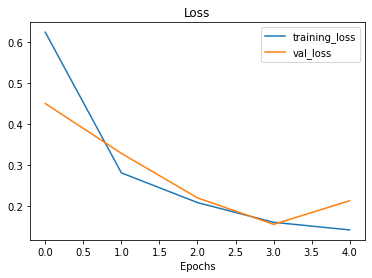

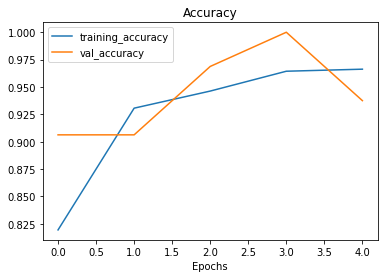

In [29]:
plot_loss_curves(history_for_feature_extraction)

## **20-Unfreeze Some Layers**

In [30]:
# Unfreeze all of the layers in base model
base_model.trainable=True

# Refreeze every layer except the last 5 layer 
for layer in base_model.layers[:-5]:
  layer.trainable=False

## **21-Recompile and Fit The Model**

In [31]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lower by 10x
              metrics=METRICS)

In [32]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb7 True
global_avg_pooling_layer True
output_layer True


In [33]:
# Check which layers in our model is trainable
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable )

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block1c_dwconv False
30 block1c_bn False
31 block1c_activation False
32 block1c_se_squeeze False
33 block1c_se_reshape False
34 block1c_se_reduce False
35 block1c_se_expand False
36 block1c_se_excite False
37 block1c_project_conv False
38 block1c_project_bn False
39 block1c_drop Fal

In [35]:
# Fine-tune for more 5 epochs
fine_tune_epochs = 10 # model has already done the 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 =10)

# Fine-tune our model
history_for_fine_tune = model.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_for_feature_extraction.epoch[-1])

Epoch 5/10
100/100 [==============================] - 163s 1s/step - loss: 0.1027 - tp: 3487.0000 - fp: 73.0000 - tn: 10727.0000 - fn: 113.0000 - accuracy: 0.9733 - precision: 0.9795 - recall: 0.9686 - auc: 0.9989 - val_loss: 0.1462 - val_tp: 30.0000 - val_fp: 1.0000 - val_tn: 95.0000 - val_fn: 2.0000 - val_accuracy: 0.9688 - val_precision: 0.9677 - val_recall: 0.9375 - val_auc: 0.9987
Epoch 6/10
100/100 [==============================] - 131s 1s/step - loss: 0.0757 - tp: 3125.0000 - fp: 58.0000 - tn: 9542.0000 - fn: 75.0000 - accuracy: 0.9794 - precision: 0.9818 - recall: 0.9766 - auc: 0.9992 - val_loss: 0.0836 - val_tp: 32.0000 - val_fp: 0.0000e+00 - val_tn: 96.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 7/10
100/100 [==============================] - 131s 1s/step - loss: 0.0534 - tp: 3146.0000 - fp: 41.0000 - tn: 9559.0000 - fn: 54.0000 - accuracy: 0.9859 - precision: 0.9871 - recall: 0.9831 - auc: 0.9997 - va

## **22-Re_Evaluate The Model**

In [36]:
# Evaluate on the whole test dataset
fine_tune_results =model.evaluate(test_data)
fine_tune_results

13/13 [==============================] - 11s 835ms/step - loss: 0.0263 - tp: 399.0000 - fp: 1.0000 - tn: 1199.0000 - fn: 1.0000 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000


[0.026277847588062286,
 399.0,
 1.0,
 1199.0,
 1.0,
 0.9975000023841858,
 0.9975000023841858,
 0.9975000023841858,
 0.9999749064445496]

## **23-Compare Histories**

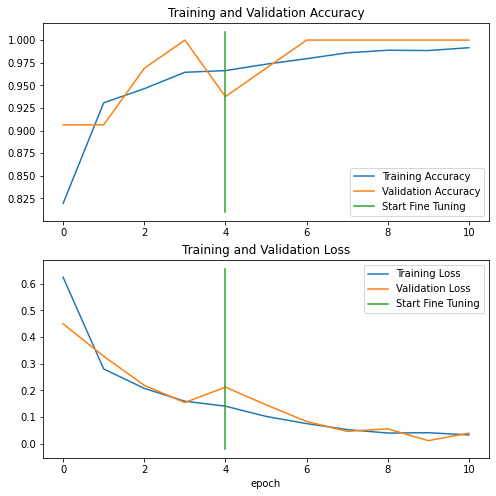

In [37]:
# Compare the historys of feature extraction model with fine-tuning model 
compare_historys(original_history=history_for_feature_extraction,
                 new_history=history_for_fine_tune,
                 initial_epochs=5)

## **24-Save The Model**

In [38]:
# Save our fine-tuning model
model.save("drive/MyDrive/apple_dataset_model.h5")

## **25-Load The Model**

In [39]:
# Load and evaluate saved model
loaded_model =tf.keras.models.load_model("drive/MyDrive/apple_dataset_model.h5")

In [40]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

13/13 [==============================] - 17s 810ms/step - loss: 0.0263 - tp: 399.0000 - fp: 1.0000 - tn: 1199.0000 - fn: 1.0000 - accuracy: 0.9975 - precision: 0.9975 - recall: 0.9975 - auc: 1.0000


[0.026277847588062286,
 399.0,
 1.0,
 1199.0,
 1.0,
 0.9975000023841858,
 0.9975000023841858,
 0.9975000023841858,
 0.9999749064445496]

In [43]:
# The results from the saved model (Above) should be very similar to the results below
fine_tune_results

[0.026277847588062286,
 399.0,
 1.0,
 1199.0,
 1.0,
 0.9975000023841858,
 0.9975000023841858,
 0.9975000023841858,
 0.9999749064445496]

## **26-Make Prediction Probabilites**

In [44]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it left

13/13 [==============================] - 16s 802ms/step


In [45]:
len(test_data)

13

In [46]:
# How many predictions are there?
len(preds_probs)

400

In [47]:
# What's the shape of our predictions?
preds_probs.shape

(400, 4)

In [48]:
# Let's see whats the first 10 predictions looks like
preds_probs[:10]

array([[7.83074617e-01, 3.55876633e-03, 2.13170320e-01, 1.96261302e-04],
       [7.88840592e-01, 1.19055714e-03, 4.02525775e-02, 1.69716284e-01],
       [8.55334222e-01, 5.99471889e-07, 1.40262389e-04, 1.44524977e-01],
       [9.77485240e-01, 2.01579109e-02, 1.67253509e-03, 6.84332452e-04],
       [9.84006107e-01, 1.67532067e-03, 1.42101366e-02, 1.08409775e-04],
       [9.84685183e-01, 7.35819822e-06, 7.62827869e-04, 1.45445727e-02],
       [9.96410429e-01, 2.75744842e-05, 2.36708624e-03, 1.19496800e-03],
       [9.92723167e-01, 2.19705442e-04, 7.03246216e-04, 6.35380624e-03],
       [9.98708844e-01, 1.60920070e-04, 9.56894655e-06, 1.12057966e-03],
       [9.98769104e-01, 1.38952077e-04, 6.86989108e-04, 4.04897466e-04]],
      dtype=float32)

In [49]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([7.8307462e-01, 3.5587663e-03, 2.1317032e-01, 1.9626130e-04],
       dtype=float32), 4, 0.999999964813469)

In [50]:
# We get one prediction probability per class(in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilites for sample 0: {len(preds_probs[0])}")
print(f"What prediction probabilites sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")


Number of prediction probabilites for sample 0: 4
What prediction probabilites sample 0 looks like:
 [7.8307462e-01 3.5587663e-03 2.1317032e-01 1.9626130e-04]
The class with highest predicted probability by the model for sample 0: 0


In [51]:
# Get the pred classes of each model
pred_classes = preds_probs.argmax(axis=1)

# How do they look like?
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [52]:
# How many pred classes we have?
len(pred_classes)

400

In [53]:
# To get our test dataset labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,.....0,0], we want the index value where the index value "1" occurs
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [54]:
# How many y_labels are there?
len(y_labels)

400

In [55]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [56]:
len(test_data)

13

## **27-Make Confusion Matrix**

In [58]:
from helper_functions import make_confusion_matrix

In [59]:
# Get a list of class names
class_names =test_data.class_names
class_names[:10]

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy']

In [60]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-label print verticaly
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changes (x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

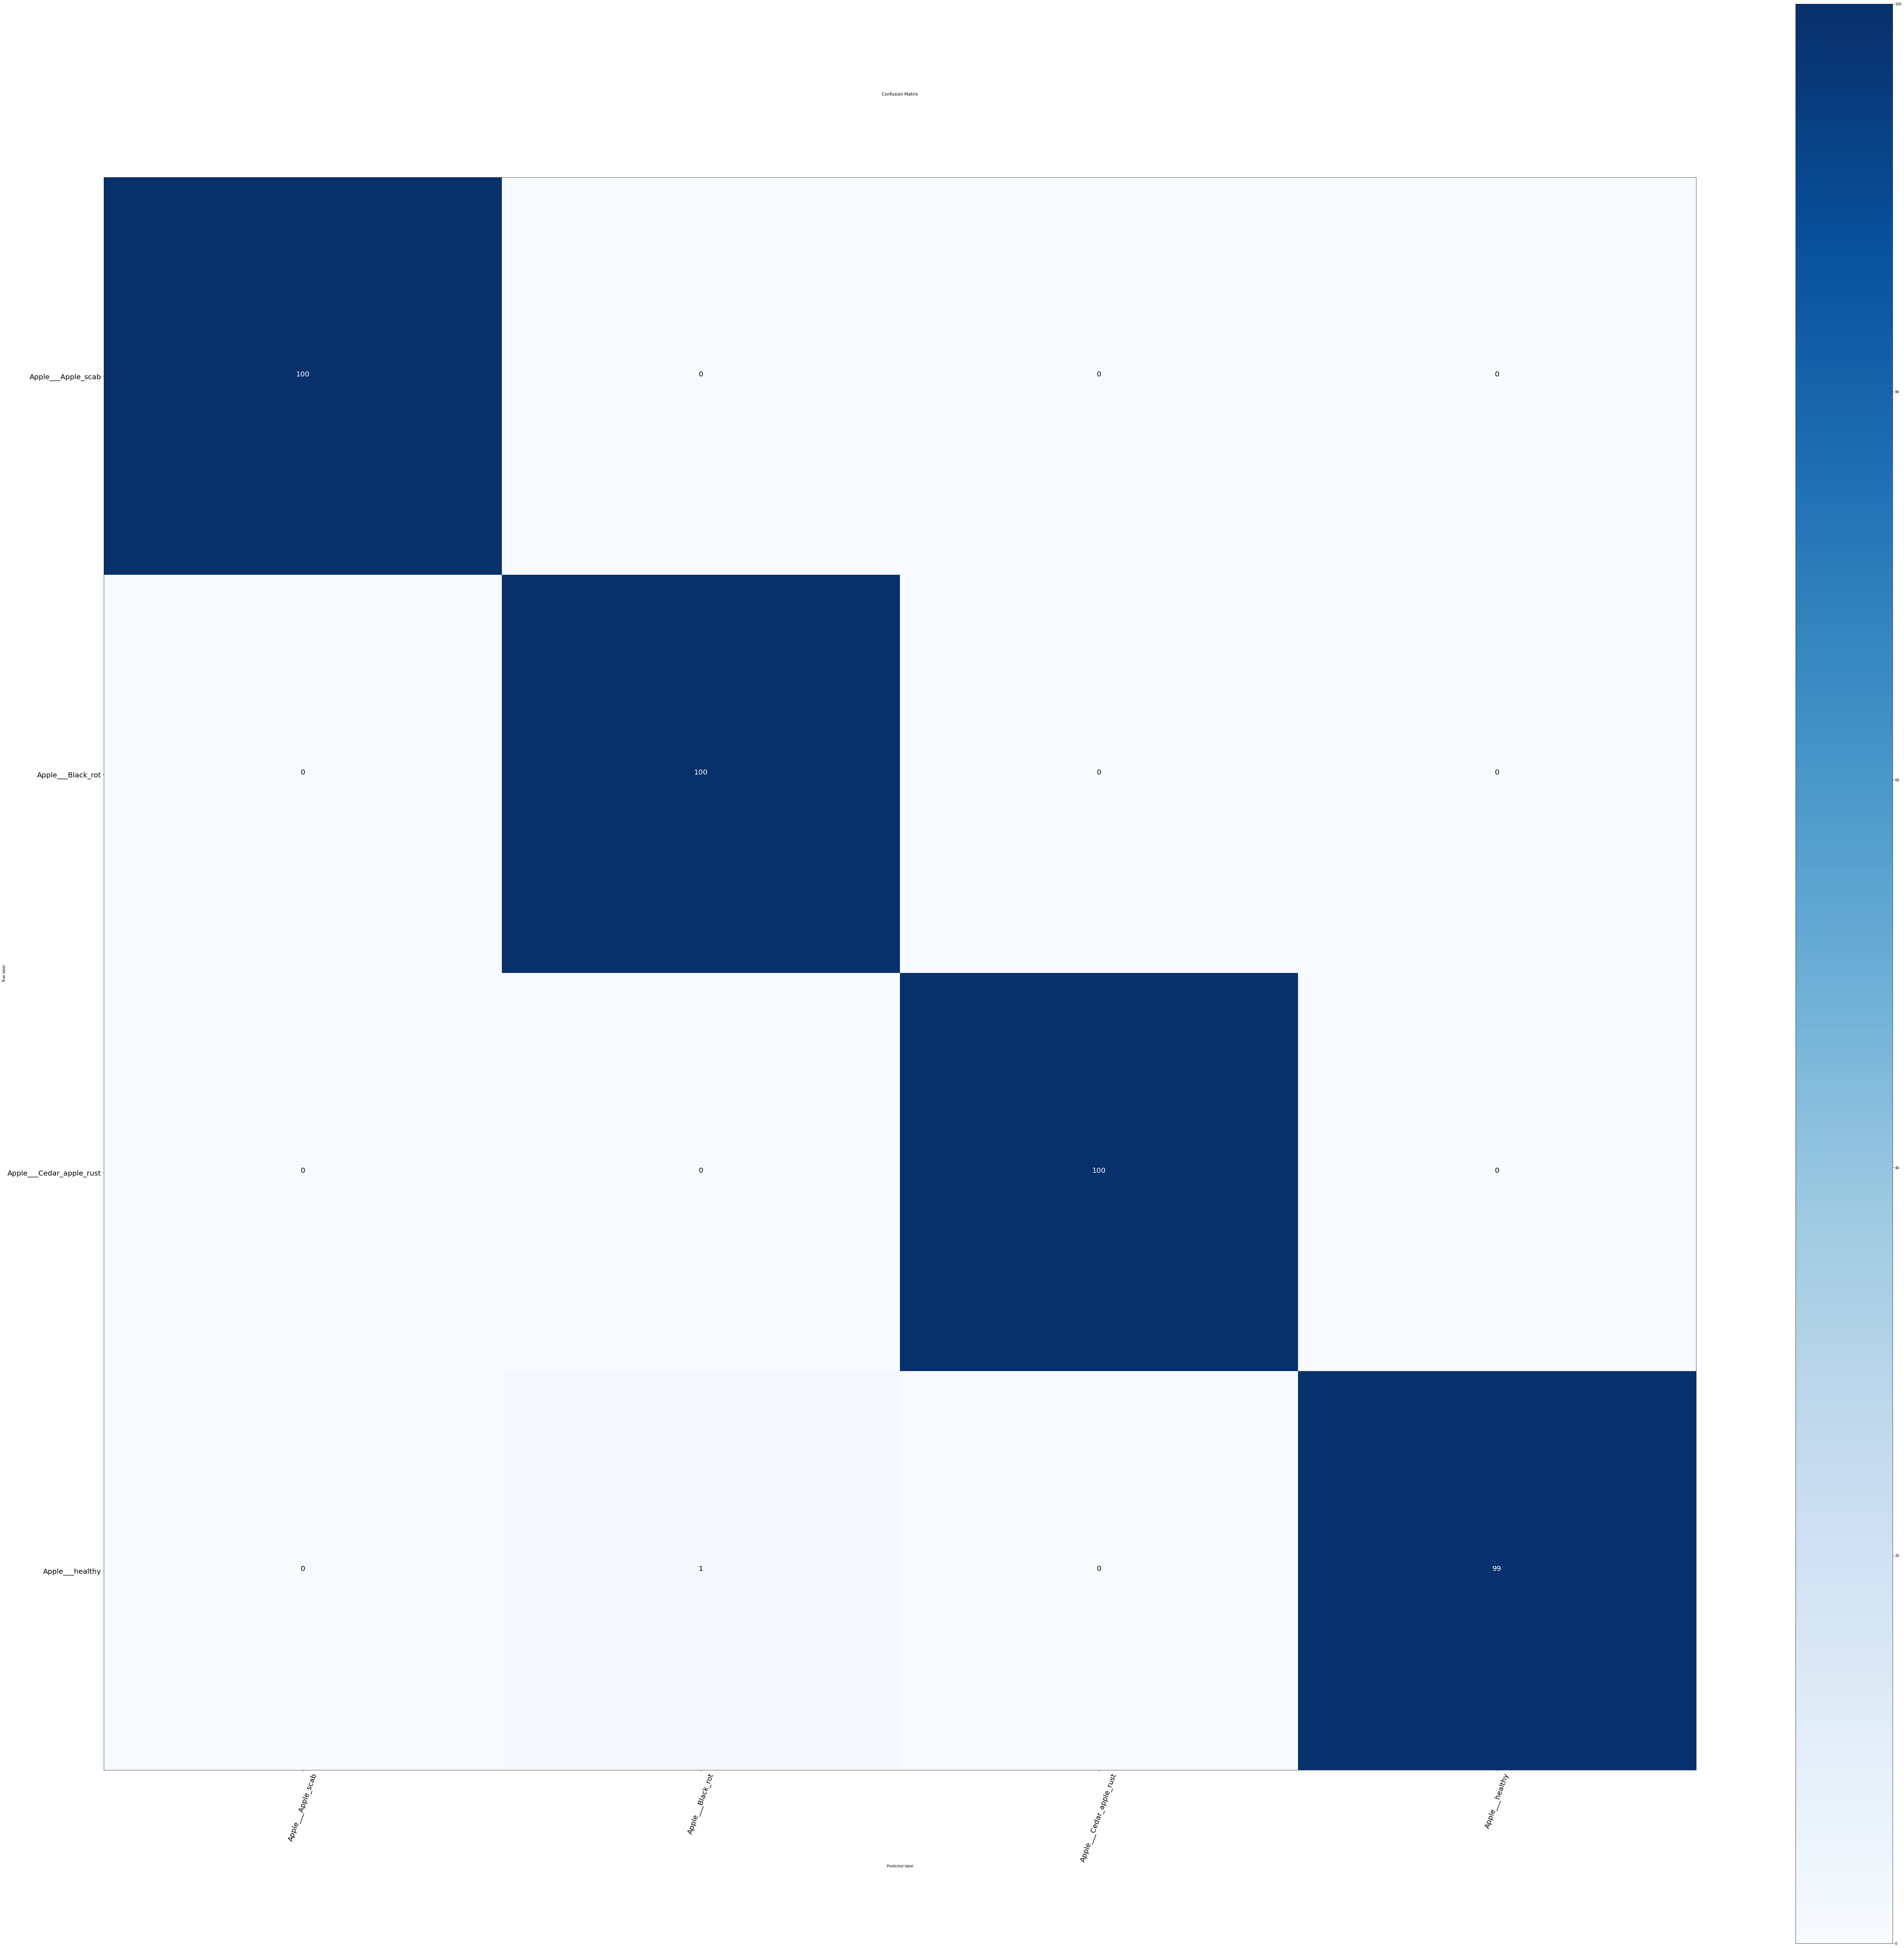

In [61]:
make_confusion_matrix(y_true=y_labels,
                       y_pred=pred_classes,
                       classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## **28-Make Classification Report**

In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       0.99      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      0.99      0.99       100

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [63]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 100},
 '1': {'f1-score': 0.9950248756218906,
  'precision': 0.9900990099009901,
  'recall': 1.0,
  'support': 100},
 '2': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 100},
 '3': {'f1-score': 0.9949748743718593,
  'precision': 1.0,
  'recall': 0.99,
  'support': 100},
 'accuracy': 0.9975,
 'macro avg': {'f1-score': 0.9974999374984375,
  'precision': 0.9975247524752475,
  'recall': 0.9975,
  'support': 400},
 'weighted avg': {'f1-score': 0.9974999374984376,
  'precision': 0.9975247524752475,
  'recall': 0.9975,
  'support': 400}}

In [66]:
class_names[3]

'Apple___healthy'

In [67]:
classification_report_dict["3"]["f1-score"]

0.9949748743718593

In [68]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
     # Add names and f1-scores to new dictionary
     class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores     


{'Apple___Apple_scab': 1.0,
 'Apple___Black_rot': 0.9950248756218906,
 'Apple___Cedar_apple_rust': 1.0,
 'Apple___healthy': 0.9949748743718593}

In [71]:
# Turn f1 scores into Dataframe visualization
import pandas as pd
f1_scores =pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores                

,class_names,f1-score
0,Apple___Apple_scab,1.000000
2,Apple___Cedar_apple_rust,1.000000
1,Apple___Black_rot,0.995025
3,Apple___healthy,0.994975


In [72]:
f1_scores[:2]

,class_names,f1-score
0,Apple___Apple_scab,1.0
2,Apple___Cedar_apple_rust,1.0


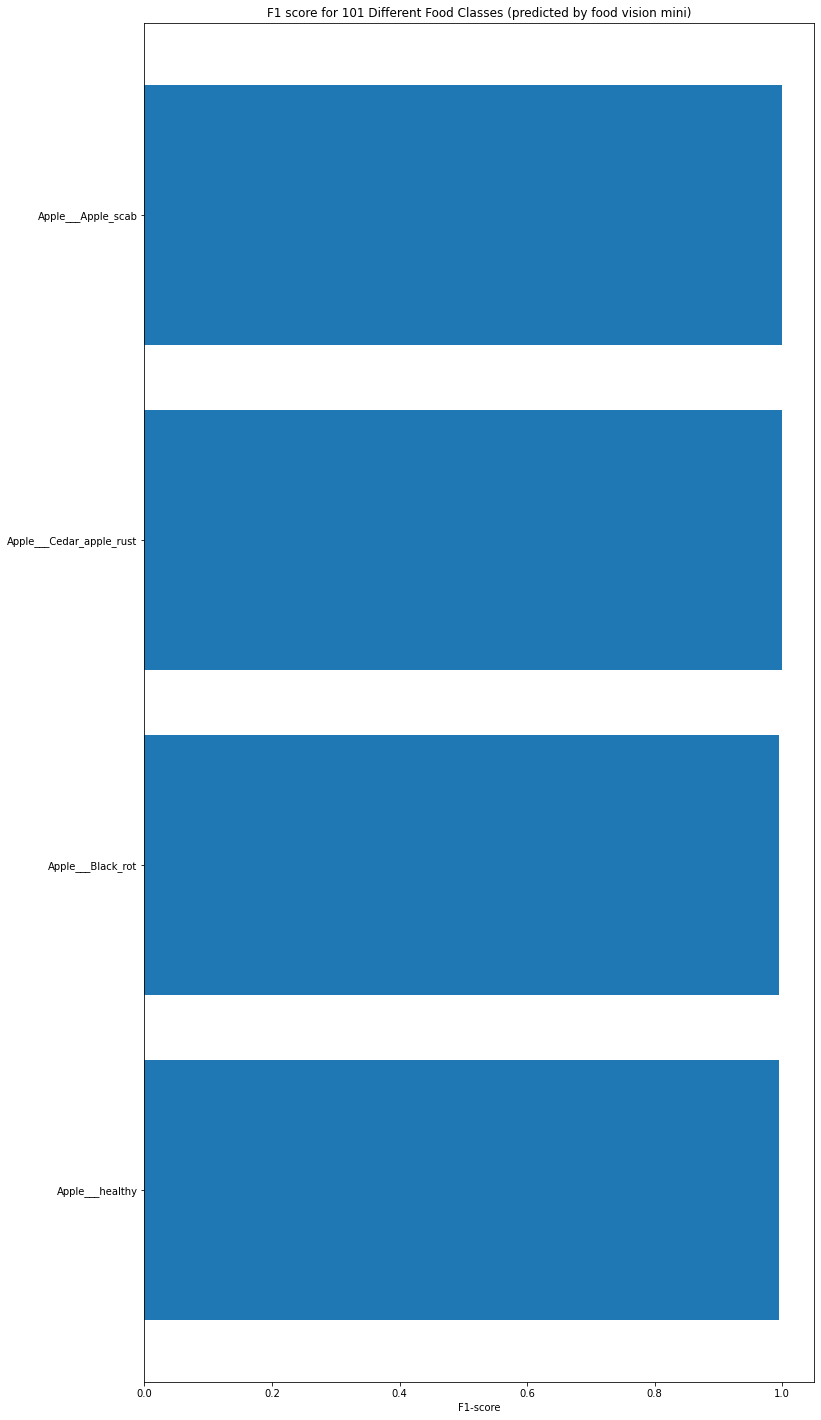

In [73]:
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score value
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 Different Food Classes (predicted by food vision mini)")
ax.invert_yaxis(); # reverse the order of our plot


# Challenge: add value to the end of each bar of what the actual f1-score is 
# (hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html) 

## **29-Load and Prepare Images Function**

In [74]:
# Create a function to load and create a images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Read in an image from filename, turn it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename(str): path to target image
    image_shape(int): height/width dimension of target image size
    scale(bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3) 

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale Yes/no?
  if scale:
    # reshape the image (get all value between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale image for EffiecienNet model in TensorFlow   


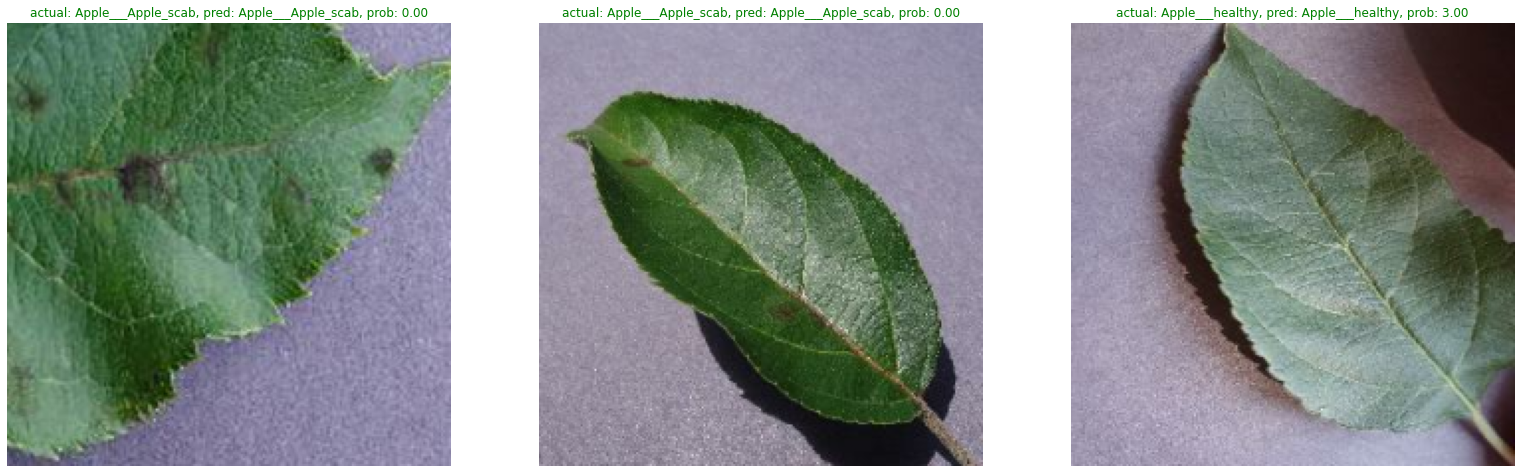

In [76]:
# Make preds on series of images
import os
import random

plt.figure(figsize=(27,10))
for i in range(3):
  # Choose a random image(s) from a random class(es)
  class_name =random.choice(class_names)
  filename = random.choice(os.listdir(val_dir + "/" + class_name))
  filepath = val_dir + class_name + "/" + filename


  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  # print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probability array
  pred_class = class_names[pred_prob.argmax()] # get heighst prediction probability index and match it class_names list
  # print(pred_prob)
   # print(pred_class)

    # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color ="r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.argmax():.2f}", c=title_color)
  plt.axis(False);  

In [93]:
img = "/content/apple rust.jpg"

(-0.5, 223.5, 223.5, -0.5)

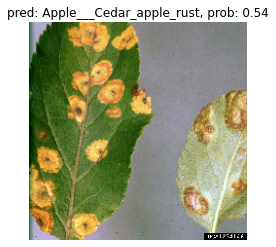

In [94]:
# Make prediction on and plot the custom food images
img = load_and_prep_image(img, scale=False) # don't need to do scale for our EfficienNetB0 model
pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on the image with shape [1, 224,224, 1] (same shape as model trained on)
pred_class = class_names[pred_prob.argmax()] # get the index with heighest prediction probability
# plot the appropriate information
plt.figure()
plt.imshow(img/255.)
plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
plt.axis(False)